In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [36]:
import numpy as np
import pandas as pd
import os
from Datasets import Dataset
from Split import train_test_split
from Split import get_cv
from data_readers import MovieLens_reader,FilmTrust_reader,MovieLens1M_reader,Netflix_reader
from Algs import SVD,NMF,ULV,ULV_PSO,ULV_Momentum
import accuracy
from utils import save_matrix_as_excel,compare_plot,save_matrix_array,read_file_excel_result
import pickle


data_storage = 'Datasets'
result_storage = 'Results'
#data_filenames = ['MovieLens_100k','MovieLens1M,'filmtrust','Netflix']
file_name = 'MovieLens_100k'

#algorithms = ['SVD','NMF','ULV','ULVPSO']
algorithms = ['ULV']

# learning rates
#learning_rates = [0.002,0.004,0.006,0.01]
learning_rates =  np.linspace(0.001,0.1,5)
# learning_rates=[0.1]
#epochs
n_epochs = 5

#number kfold
cv = 3

In [12]:
learning_rateshh =  np.linspace(0.002,0.02,10)
learning_rateshh

array([0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016, 0.018,
       0.02 ])

In [63]:
# get current working directory
# cwd = '/content/drive/MyDrive/project_t/pyCodes(8)-cv_v2'
cwd = os.getcwd()
data_path = os.path.join(cwd,data_storage)


if file_name == 'MovieLens_100k':
    reader = MovieLens_reader
    fullfile_name = os.path.join(data_path,file_name+'.txt')

if file_name == 'MovieLens1M':
    reader = MovieLens1M_reader
    fullfile_name = os.path.join(data_path,file_name+'.txt')

if file_name == 'filmtrust':
    reader = FilmTrust_reader
    fullfile_name = os.path.join(data_path,file_name+'.txt')

if file_name == 'Netflix':
    reader = Netflix_reader
    fullfile_name = os.path.join(data_path,file_name+'.txt')

# results save path
save_path = os.path.join(cwd,result_storage,'CrossValidation',file_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

# results save path
save_path_result_kfold = os.path.join(cwd,result_storage,'CrossValidation',file_name,'data_save')
if not os.path.exists(save_path_result_kfold):
    os.makedirs(save_path_result_kfold)


In [ ]:
#-----------------------------------------------------------فراخوانی فایل دیتا ها و ذخیره ان ها --------------------------------------------------


# load dataset
data = Dataset.load_from_file(fullfile_name,reader)
save_matrix_array(data,save_path_result_kfold,'data_kfold_'+file_name+'_data')


In [54]:
#----------------------------------------لود کردن فایل دخیر شده دیتا ---------------------------------------

# cwd = '/content/drive/MyDrive/project_t/pyCodes(8)-cv_v2'
cwd = os.getcwd()
save_path_result_kfold = os.path.join(cwd,result_storage,'CrossValidation',file_name,'data_save','data_kfold_'+file_name+'_data')
if not os.path.exists(save_path_result_kfold):
    print("no file kfold")
else:
    with open(save_path_result_kfold, 'rb') as f:  # 'rb' برای خواندن در فرمت باینری
        data = pickle.load(f)
        print(file_name+' File loaded.')
    #print(data_kfold)

MovieLens_100k File loaded.


In [55]:
data.raw_ratings

array([[      196,       242,         3, 881250949],
       [      186,       302,         3, 891717742],
       [       22,       377,         1, 878887116],
       ...,
       [      276,      1090,         1, 874795795],
       [       13,       225,         2, 882399156],
       [       12,       203,         3, 879959583]], dtype=int64)

In [58]:
#------------------------------------------تعمین میزان  تعداد رتبه های مورد استفاده  کاربرد در دیتاست نتفلیکس---------------------------------
import numpy as np

if file_name=='Netflix':
    # فرض بر این است که data.raw_ratings به صورت numpy array است
    total_rows = data.raw_ratings.shape[0]

# عدد ردیف مورد نیاز
    sample_size = 184923

# انتخاب شاخص‌های تصادفی بدون تکرار
    random_indices = np.random.choice(total_rows, size=sample_size, replace=False)

# برداشت ردیف‌های تصادفی
    data.raw_ratings = data.raw_ratings[random_indices]
    
    #--------------------------------ذخیره فایل تعمین میزان  تعداد رتبه های مورد استفاده  کاربرد در دیتاست نتفلیکس-----------------------------------
    save_path_result_kfold = os.path.join(cwd,result_storage,'CrossValidation',file_name,'data_save')

    save_matrix_array(data,save_path_result_kfold,'data_kfold_'+file_name+'_data_184923')
else:
    pass



In [59]:
#----------------------------------------لود کردن فایل دخیر شده  تعمین میزان  تعداد رتبه های مورد استفاده  کاربرد در دیتاست نتفلیکس----------------------------------------

if file_name=='Netflix':
    # cwd = '/content/drive/MyDrive/project_t/pyCodes(8)-cv_v2'
    cwd = os.getcwd()
    save_path_result_kfold = os.path.join(cwd,result_storage,'CrossValidation',file_name,'data_save','data_kfold_'+file_name+'_data_184923')
    if not os.path.exists(save_path_result_kfold):
        print("no file kfold")
    else:
        with open(save_path_result_kfold, 'rb') as f:  # 'rb' برای خواندن در فرمت باینری
            data = pickle.load(f)
            print(file_name+' File loaded.')
        #print(data_kfold)
else:
    pass

In [60]:
len(data.raw_ratings)

100000

In [64]:
#------------------------------------------------------ تقسیم داده ها به k-fold و ذخیره ان --------------------------------------

cv = get_cv(cv)
cv_num = 0

data_list_kfold = []
for trainset, testset in cv.split(data):
        cv_num = cv_num + 1
        print("fold ", cv_num, " created")
        df_kfold_s = [trainset,testset]
        data_list_kfold.append(df_kfold_s)

save_matrix_array(data_list_kfold,save_path_result_kfold,'data_kfold_'+file_name)

fold  1  created
fold  2  created
fold  3  created


In [66]:
#------------------------------------------لود فایل داده های k-foldتقسیم شده -----------------------------------

# cwd = '/content/drive/MyDrive/project_t/pyCodes(8)-cv_v2'
cwd = os.getcwd()
save_path_result_kfold = os.path.join(cwd,result_storage,'CrossValidation',file_name,'data_save','data_kfold_'+file_name)
if not os.path.exists(save_path_result_kfold):
    print("no file kfold")
else:
    with open(save_path_result_kfold, 'rb') as f:  # 'rb' برای خواندن در فرمت باینری
        data_list_kfold = pickle.load(f)
        print(file_name+' File loaded.')
    #print(data_kfold)

MovieLens_100k File loaded.


In [67]:
j=data_list_kfold[0][0]


In [68]:
j.n_ratings

66666

In [69]:
j.n_users

943

In [70]:
j.n_items

1629

In [71]:
c= j.ir

In [72]:
c[20]

[(19, 3),
 (192, 3),
 (60, 4),
 (242, 5),
 (509, 3),
 (434, 3),
 (401, 2),
 (774, 4),
 (493, 5),
 (165, 3),
 (455, 3),
 (52, 3),
 (207, 3),
 (341, 3),
 (264, 1),
 (449, 4),
 (685, 4),
 (511, 3),
 (573, 2),
 (313, 2),
 (369, 4),
 (789, 1),
 (239, 2),
 (330, 4),
 (556, 2),
 (216, 3),
 (571, 3),
 (149, 3),
 (53, 2),
 (1, 4),
 (11, 1),
 (267, 4),
 (605, 3),
 (159, 2),
 (452, 3),
 (56, 3),
 (102, 3),
 (226, 2),
 (241, 4),
 (28, 3),
 (326, 4),
 (524, 4),
 (51, 3),
 (12, 4),
 (589, 3),
 (47, 3),
 (373, 4),
 (632, 3),
 (408, 3),
 (628, 4),
 (17, 2),
 (258, 4),
 (232, 4),
 (80, 3),
 (660, 4),
 (817, 4),
 (215, 3),
 (65, 2),
 (96, 3),
 (59, 3),
 (726, 3),
 (134, 2),
 (116, 2),
 (245, 4),
 (210, 2),
 (850, 2),
 (298, 3),
 (263, 2),
 (607, 3),
 (516, 3),
 (431, 3),
 (482, 2),
 (611, 4),
 (585, 5),
 (243, 3),
 (539, 3),
 (224, 3),
 (68, 3),
 (3, 2),
 (451, 3),
 (115, 2),
 (32, 4),
 (836, 2),
 (603, 3),
 (185, 4),
 (253, 1),
 (377, 3),
 (174, 4),
 (120, 2),
 (292, 3),
 (569, 5),
 (71, 3),
 (312, 1),

In [73]:
k= j.ur


In [74]:
k[0]

[(0, 3),
 (108, 5),
 (316, 4),
 (607, 3),
 (280, 3),
 (477, 3),
 (109, 4),
 (256, 3),
 (253, 4),
 (1041, 3),
 (1054, 3),
 (335, 3),
 (504, 4),
 (951, 3),
 (305, 2),
 (195, 2),
 (372, 4),
 (390, 3),
 (579, 3),
 (481, 3),
 (65, 4),
 (1215, 2),
 (599, 2),
 (1142, 1),
 (1111, 3),
 (268, 4),
 (188, 2),
 (568, 3),
 (263, 3),
 (658, 4),
 (590, 3),
 (619, 3),
 (701, 3),
 (3, 4),
 (1206, 2),
 (94, 3),
 (635, 4),
 (145, 3),
 (139, 3),
 (136, 5),
 (50, 4),
 (251, 3),
 (192, 2),
 (1373, 5),
 (447, 3),
 (601, 4),
 (288, 4),
 (164, 4),
 (9, 2),
 (506, 4),
 (59, 3),
 (479, 5),
 (102, 3),
 (1271, 3),
 (533, 3),
 (777, 4),
 (209, 3),
 (362, 3),
 (999, 3),
 (1050, 2),
 (292, 4),
 (1244, 4),
 (484, 5),
 (592, 4),
 (483, 4),
 (938, 3),
 (889, 3),
 (633, 4),
 (498, 2),
 (79, 4),
 (663, 3),
 (38, 3),
 (56, 4),
 (387, 2),
 (334, 4),
 (467, 3),
 (44, 3),
 (111, 3),
 (64, 3),
 (480, 2),
 (811, 2),
 (1457, 2),
 (366, 4),
 (106, 3),
 (913, 2),
 (183, 3),
 (299, 3),
 (493, 3),
 (239, 4),
 (114, 4),
 (187, 3),
 (3

In [75]:
j=data_list_kfold[0][0]

trainset_pivot2 = np.zeros((j.n_users,j.n_items),dtype=float)
for u, i, r in j.all_ratings():
    print(u,"------------",i,"---------",r)
    trainset_pivot2[u,i]=r

0 ------------ 0 --------- 3
0 ------------ 108 --------- 5
0 ------------ 316 --------- 4
0 ------------ 607 --------- 3
0 ------------ 280 --------- 3
0 ------------ 477 --------- 3
0 ------------ 109 --------- 4
0 ------------ 256 --------- 3
0 ------------ 253 --------- 4
0 ------------ 1041 --------- 3
0 ------------ 1054 --------- 3
0 ------------ 335 --------- 3
0 ------------ 504 --------- 4
0 ------------ 951 --------- 3
0 ------------ 305 --------- 2
0 ------------ 195 --------- 2
0 ------------ 372 --------- 4
0 ------------ 390 --------- 3
0 ------------ 579 --------- 3
0 ------------ 481 --------- 3
0 ------------ 65 --------- 4
0 ------------ 1215 --------- 2
0 ------------ 599 --------- 2
0 ------------ 1142 --------- 1
0 ------------ 1111 --------- 3
0 ------------ 268 --------- 4
0 ------------ 188 --------- 2
0 ------------ 568 --------- 3
0 ------------ 263 --------- 3
0 ------------ 658 --------- 4
0 ------------ 590 --------- 3
0 ------------ 619 --------- 3
0 ----

In [76]:
trainset_pivot2.shape

(943, 1629)

In [77]:
len(data_list_kfold[0][1])

33334

-----------------------( 1 )--------------------------------
kfold =  1 ---- algorithm =  ULV ----learning_rates----> 0.001
Processing epoch 0
mse =  1.2210692725679535
Processing epoch 1
mse =  1.1430222192456556
Processing epoch 2
mse =  1.0910191158153817
Processing epoch 3
mse =  1.0540481373390902
Processing epoch 4
mse =  1.0264247320881372
RMSE: 1.0121
MSE: 1.0243
MAE:  0.8225
Precision: 0.8734, Recall: 0.5086, F1: 0.6429
kfold =  1 ---- algorithm =  ULV ----learning_rates----> 0.025750000000000002
Processing epoch 0
mse =  0.9957940677311199
Processing epoch 1
mse =  0.8963074851671549
Processing epoch 2
mse =  0.8701057224854664
Processing epoch 3
mse =  0.8452425081279065
Processing epoch 4
mse =  0.8059620292073402
RMSE: 0.9321
MSE: 0.8688
MAE:  0.7367
Precision: 0.8667, Recall: 0.7557, F1: 0.8074
kfold =  1 ---- algorithm =  ULV ----learning_rates----> 0.0505
Processing epoch 0
mse =  0.9752946148640066
Processing epoch 1
mse =  0.8888988123383101
Processing epoch 2
mse =  

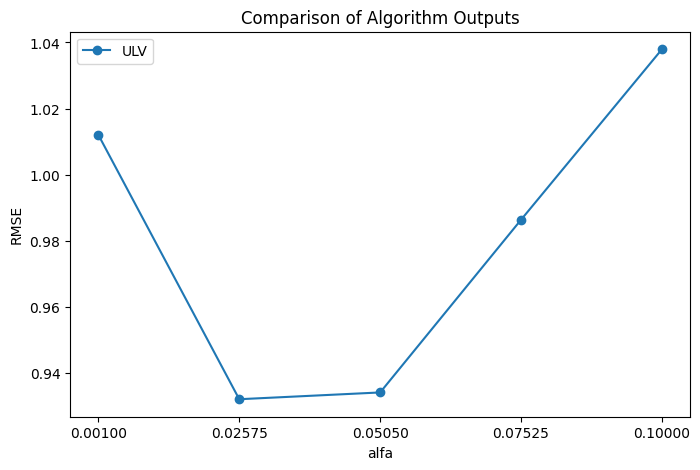

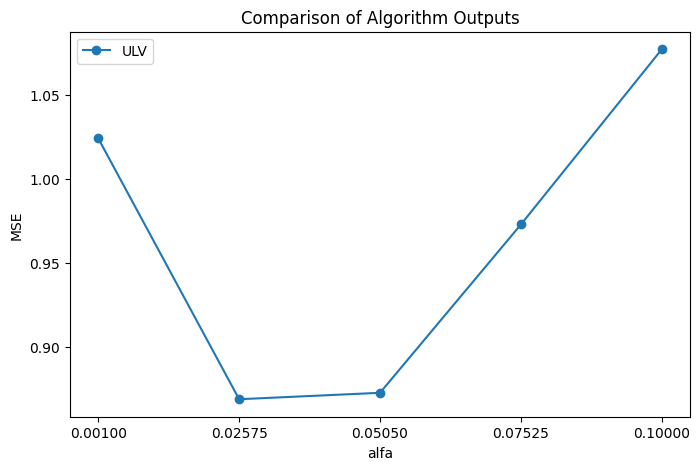

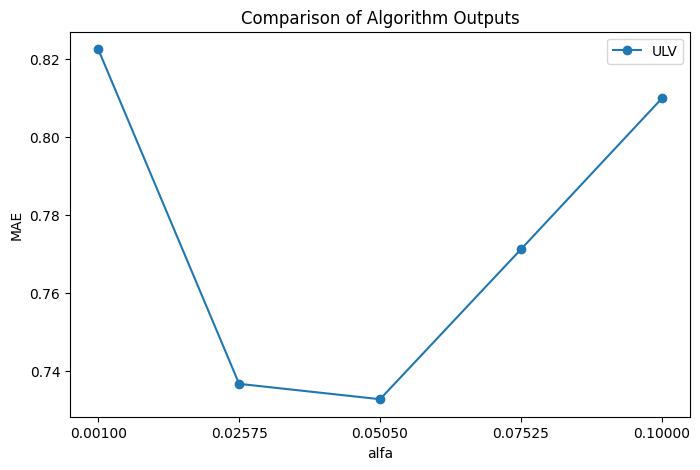

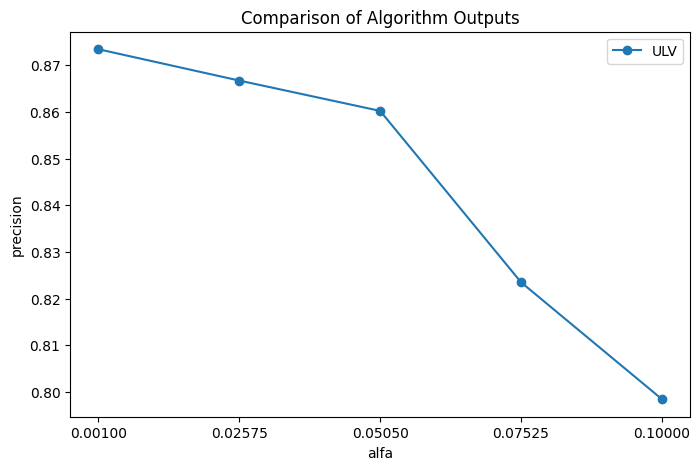

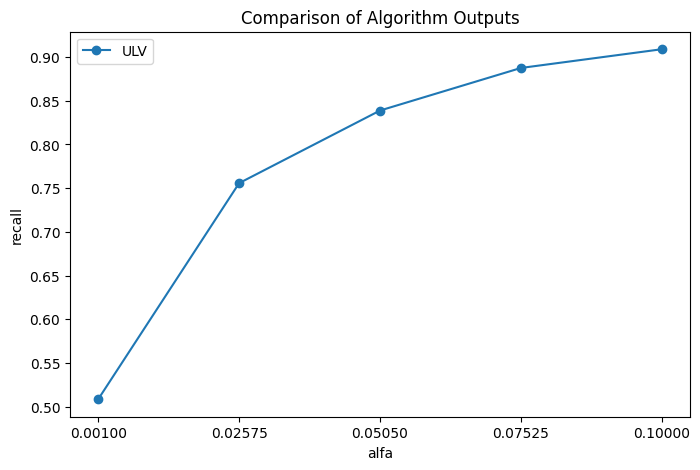

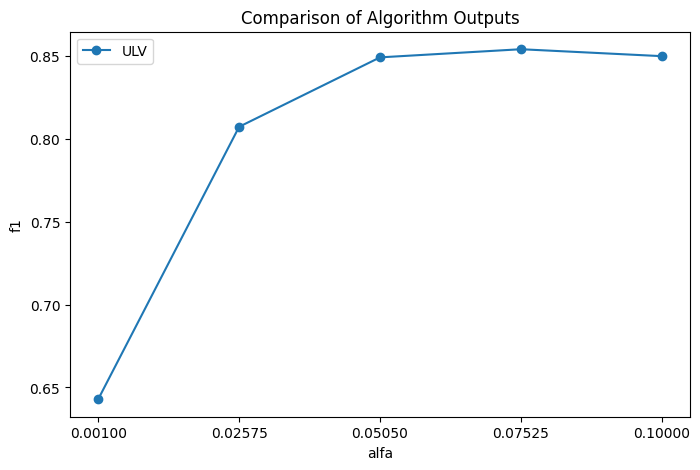

In [78]:
number_fold = 0

print('-----------------------(',number_fold+1,')--------------------------------')

trainset = data_list_kfold[number_fold][0]
testset = data_list_kfold[number_fold][1]

m = len(algorithms)
n = np.shape(learning_rates)[0]

RMSE_folds = np.zeros((m,n))
MSE_folds = np.zeros((m,n))
MAE_folds = np.zeros((m,n))
precision = np.zeros((m,n))
recall = np.zeros((m,n))
f1 = np.zeros((m,n))



for i in range(m):
    algorithm = algorithms[i]

    for j in range(n):
        alfa = learning_rates[j]

        if algorithm == 'SVD':
            alg = SVD(n_epochs=n_epochs,n_factors=50,lr_all=alfa,biased=True,verbose=True)

        if algorithm == 'NMF':
            alg = NMF(n_epochs=n_epochs,n_factors=50,lr_bu=alfa, lr_bi=alfa,verbose=True)

        if algorithm == 'ULV':
            alg = ULV(n_epochs=n_epochs,n_factors=50,lr_all=alfa,verbose=True)

        if algorithm == 'ULVPSO':
            alg = ULV_PSO(n_epochs=n_epochs,n_factors=50,lr_all=alfa,verbose=True)
        if algorithm == 'ULV_Momentum':
            alg = ULV_Momentum(n_epochs=n_epochs,n_factors=50,lr_all=alfa,verbose=True)
        

        print("kfold = ",number_fold+1,"---- algorithm = ",algorithm ,"----learning_rates---->",alfa)

        

        alg.fit(trainset)
        predictions = alg.test(testset)
        RMSE_folds[i,j] = accuracy.rmse(predictions)
        MSE_folds[i,j] = accuracy.mse(predictions)
        MAE_folds[i,j] = accuracy.mae(predictions)
        precision[i,j], recall[i,j], f1[i,j] = accuracy.another_measures(predictions)

save_path_result_kfold_number = os.path.join(cwd,result_storage,'CrossValidation',file_name,'k('+str(number_fold+1)+')')
if not os.path.exists(save_path_result_kfold_number):
    os.makedirs(save_path_result_kfold_number)

save_matrix_as_excel(RMSE_folds,save_path_result_kfold_number,str(number_fold)+'alfa_RMSE')
save_matrix_as_excel(MSE_folds,save_path_result_kfold_number,str(number_fold)+'alfa_MSE')
save_matrix_as_excel(MAE_folds,save_path_result_kfold_number,str(number_fold)+'alfa_MAE')

save_matrix_as_excel(precision,save_path_result_kfold_number,str(number_fold)+'alfa_precision')
save_matrix_as_excel(recall,save_path_result_kfold_number,str(number_fold)+'alfa_recall')
save_matrix_as_excel(f1,save_path_result_kfold_number,str(number_fold)+'alfa_f1')

save_matrix_as_excel(algorithms,save_path_result_kfold_number,'algorithms')
save_matrix_as_excel(learning_rates,save_path_result_kfold_number,'learning_rates')

compare_plot(learning_rates,RMSE_folds,algorithms,'alfa','RMSE',save_path_result_kfold_number,'alfa_RMSE_cmp.png')
compare_plot(learning_rates,MSE_folds,algorithms,'alfa','MSE',save_path_result_kfold_number,'alfa_MSE_cmp.png')
compare_plot(learning_rates,MAE_folds,algorithms,'alfa','MAE',save_path_result_kfold_number,'alfa_MAE_cmp.png')

compare_plot(learning_rates,precision,algorithms,'alfa','precision',save_path_result_kfold_number,'alfa_precision_cmp.png')
compare_plot(learning_rates,recall,algorithms,'alfa','recall',save_path_result_kfold_number,'alfa_recall_cmp.png')
compare_plot(learning_rates,f1,algorithms,'alfa','f1',save_path_result_kfold_number,'alfa_f1_cmp.png')

print('plots saved')

In [ ]:
RMSE_folds_m= []
MSE_folds_m= []
MAE_folds_m= []
precision_folds_m= []
recall_folds_m= []
f1_folds_m= []

for num_kfold in range(cv):
    RMSE_folds,MSE_folds,MAE_folds,precision_folds,recall_folds,f1_folds = read_file_excel_result(cwd,result_storage,file_name,num_kfold)
    RMSE_folds_m.append(RMSE_folds)
    MSE_folds_m.append(MSE_folds)
    MAE_folds_m.append(MAE_folds)
    precision_folds_m.append(precision_folds)
    recall_folds_m.append(recall_folds)
    f1_folds_m.append(f1_folds)




# لیستی برای جمع‌آوری آرایه‌های جدید
RMSE_folds_arrays= []
MSE_folds_arrays= []
MAE_folds_arrays= []
precision_folds_arrays= []
recall_folds_arrays= []
f1_folds_arrays= []

for new_array in RMSE_folds_m:
    new_array_expanded = new_array[:, :, np.newaxis]  # اضافه کردن بعد جدید
    RMSE_folds_arrays.append(new_array_expanded)  # اضافه کردن به لیست

# تبدیل لیست به آرایه نهایی، از np.concatenate استفاده می‌کنیم
RMSE_folds_m_kfold = np.concatenate(RMSE_folds_arrays, axis=2)  # چسباندن آرایه‌ها در بعد سوم


for new_array in MSE_folds_m:
    new_array_expanded = new_array[:, :, np.newaxis]
    MSE_folds_arrays.append(new_array_expanded)


MSE_folds_m_kfold = np.concatenate(MSE_folds_arrays, axis=2)


for new_array in MAE_folds_m:
    new_array_expanded = new_array[:, :, np.newaxis]
    MAE_folds_arrays.append(new_array_expanded)

MAE_folds_m_kfold = np.concatenate(MAE_folds_arrays, axis=2)

for new_array in precision_folds_m:
    new_array_expanded = new_array[:, :, np.newaxis]
    precision_folds_arrays.append(new_array_expanded)

precision_folds_m_kfold = np.concatenate(precision_folds_arrays, axis=2)

for new_array in recall_folds_m:
    new_array_expanded = new_array[:, :, np.newaxis]
    recall_folds_arrays.append(new_array_expanded)

recall_folds_m_kfold = np.concatenate(recall_folds_arrays, axis=2)

for new_array in f1_folds_m:
    new_array_expanded = new_array[:, :, np.newaxis]
    f1_folds_arrays.append(new_array_expanded)

f1_folds_m_kfold = np.concatenate(f1_folds_arrays, axis=2)

RMSE_m = np.mean(RMSE_folds_m_kfold, axis=2)
MSE_m = np.mean(MSE_folds_m_kfold, axis=2)
MAE_m = np.mean(MAE_folds_m_kfold, axis=2)
precision_m = np.mean(precision_folds_m_kfold, axis=2)
recall_m = np.mean(recall_folds_m_kfold, axis=2)
f1_m = np.mean(f1_folds_m_kfold, axis=2)


In [ ]:
precision_folds_m_kfold[:,:,4]

array([[0.87390543, 0.84126569],
       [0.55751857, 0.55735073]])

In [ ]:
recall_folds_m_kfold[:,:,4]

array([[0.08975627, 0.28932458],
       [0.9990107 , 0.9990107 ]])

In [ ]:
f1_folds_m_kfold[:,:,4]

array([[0.16279259, 0.4305695 ],
       [0.71565248, 0.71551419]])

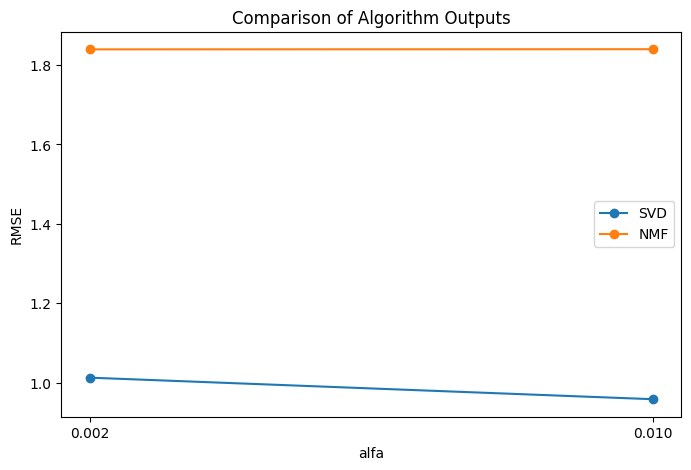

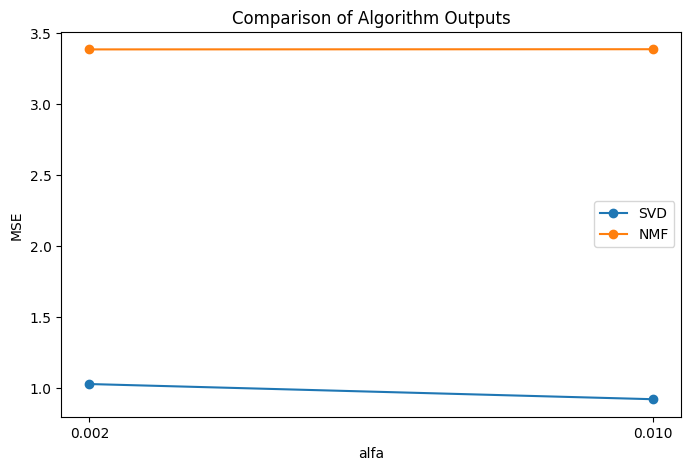

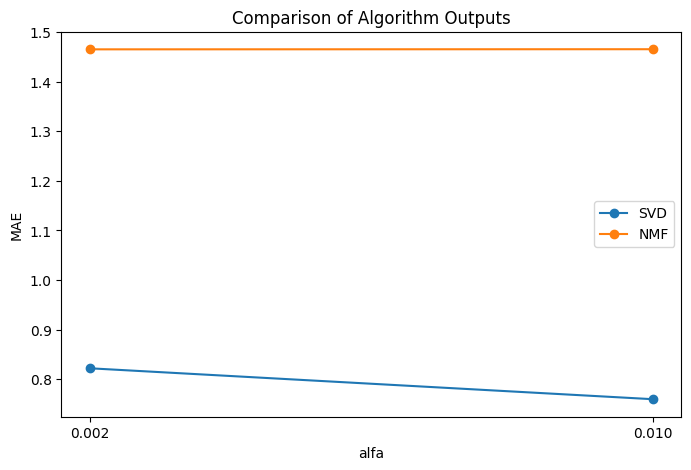

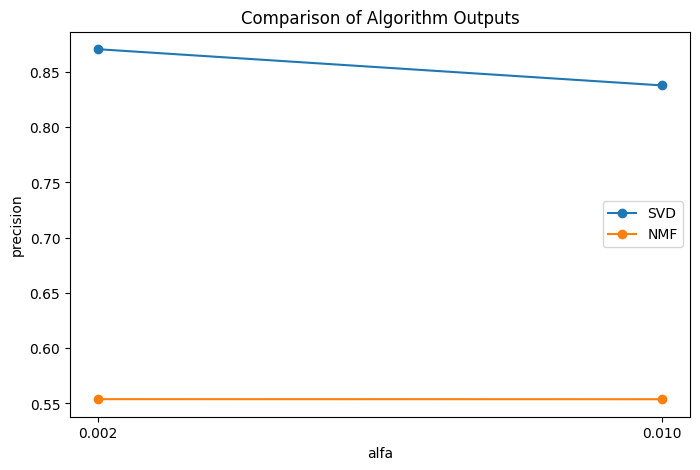

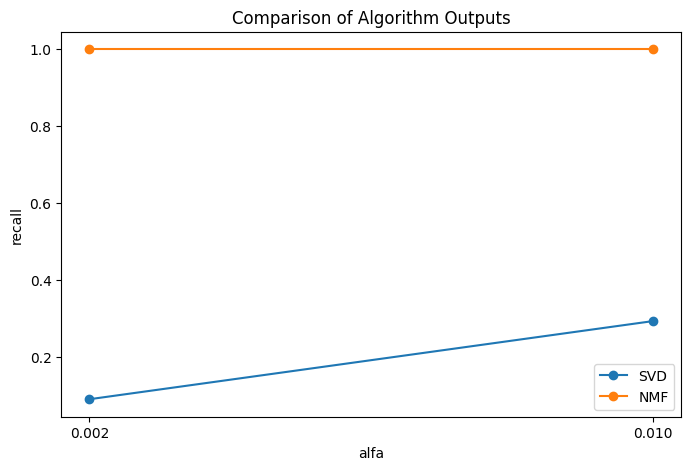

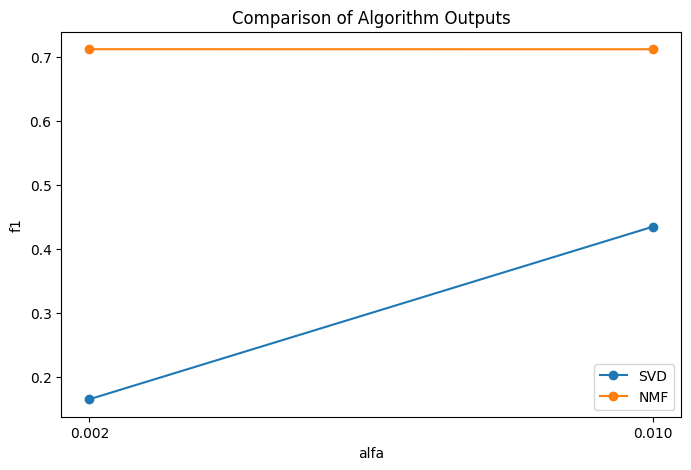

In [ ]:
# save_path = os.path.join(cwd,result_storage,file_name)

save_path_result_kfold_mean= os.path.join(cwd,result_storage,'CrossValidation',file_name,'mean_kfold_result')
if not os.path.exists(save_path_result_kfold_mean):
    os.makedirs(save_path_result_kfold_mean)

save_matrix_as_excel(RMSE_m,save_path_result_kfold_mean,'alfa_RMSE')
save_matrix_as_excel(MSE_m,save_path_result_kfold_mean,'alfa_MSE')
save_matrix_as_excel(MAE_m,save_path_result_kfold_mean,'alfa_MAE')
save_matrix_as_excel(algorithms,save_path_result_kfold_mean,'algorithms')
save_matrix_as_excel(learning_rates,save_path_result_kfold_mean,'learning_rates')

save_matrix_as_excel(precision_m,save_path_result_kfold_mean,'precision')
save_matrix_as_excel(recall_m,save_path_result_kfold_mean,'recall')
save_matrix_as_excel(f1_m,save_path_result_kfold_mean,'f1')

# plot comparisions
compare_plot(learning_rates,RMSE_m,algorithms,'alfa','RMSE',save_path_result_kfold_mean,'alfa_RMSE_cmp.png')
compare_plot(learning_rates,MSE_m,algorithms,'alfa','MSE',save_path_result_kfold_mean,'alfa_MSE_cmp.png')
compare_plot(learning_rates,MAE_m,algorithms,'alfa','MAE',save_path_result_kfold_mean,'alfa_MAE_cmp.png')

compare_plot(learning_rates,precision_m,algorithms,'alfa','precision',save_path_result_kfold_mean,'alfa_precision_cmp.png')
compare_plot(learning_rates,recall_m,algorithms,'alfa','recall',save_path_result_kfold_mean,'alfa_recall_cmp.png')
compare_plot(learning_rates,f1_m,algorithms,'alfa','f1',save_path_result_kfold_mean,'alfa_f1_cmp.png')

In [4]:
import numpy as np  
from sklearn.decomposition import NMF  

# ایجاد یک آرایه رندوم با ابعاد (6, 4)  
np.random.seed(42)  # برای تولید نتایج قابل تکرار  
trainset_pivot = np.random.rand(6, 4)  

# نمایش آرایه تصادفی  
print("آرایه تصادفی (trainset_pivot):")  
print(trainset_pivot)  

# تعداد اجزای غیرمنفی که می‌خواهیم استخراج کنیم  
n_components = 3  

# اجرای NMF  
model = NMF(n_components=n_components, init='random', random_state=0)  
W = model.fit_transform(trainset_pivot)  # ماتریس ویژگی‌ها  
H = model.components_  # ماتریس بارگذاری  

# نمایش نتایج  
print("\nماتریس ویژگی‌ها (W):")  
print(W)  
print("\nماتریس بارگذاری (H):")  
print(H.T)  

آرایه تصادفی (trainset_pivot):
[[0.37454012 0.95071431 0.73199394 0.59865848]
 [0.15601864 0.15599452 0.05808361 0.86617615]
 [0.60111501 0.70807258 0.02058449 0.96990985]
 [0.83244264 0.21233911 0.18182497 0.18340451]
 [0.30424224 0.52475643 0.43194502 0.29122914]
 [0.61185289 0.13949386 0.29214465 0.36636184]]

ماتریس ویژگی‌ها (W):
[[1.00273971 0.21550334 0.15757209]
 [0.         0.         1.34036786]
 [0.17538064 0.40146836 1.52154239]
 [0.06457722 0.88260978 0.14997702]
 [0.56135455 0.23725237 0.        ]
 [0.10063565 0.61489512 0.37712394]]

ماتریس بارگذاری (H):
[[0.15945302 0.90863859 0.12697136]
 [0.89825494 0.12318545 0.22598033]
 [0.68061383 0.17034195 0.        ]
 [0.48117839 0.07537458 0.60293227]]
